In [125]:
import cv2
import mediapipe as mp

# 初始化 MediaPipe pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

# 讀取圖片
img_path = "../../data_new/p5/DSC08606.png"  # 替換為你的圖片路徑
img = cv2.imread(img_path)


In [126]:
print(f"type = {type(img)}") 
# cv2會讀取圖片為 numpy.ndarray 類型
print(f"shape = {img.shape}")
#只有numpy.ndarray 才有 shape 屬性

type = <class 'numpy.ndarray'>
shape = (7028, 4688, 3)


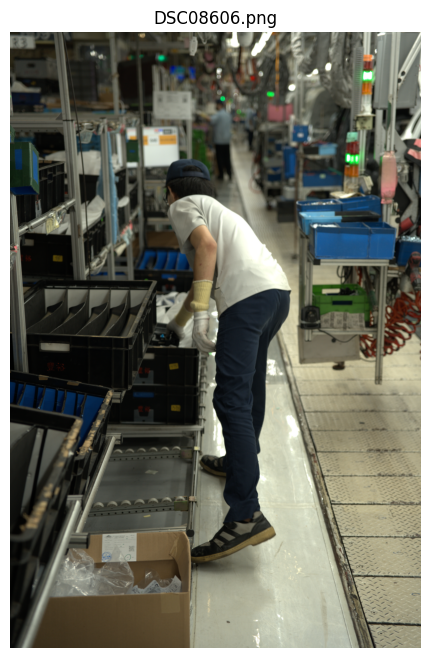

In [127]:
import matplotlib.pyplot as plt
# ✅ OpenCV 是 BGR，matplotlib 是 RGB，需要轉換
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ✅ 顯示圖片
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis('off')  # 不顯示座標軸
plt.title(img_path.split('/')[-1]) # 把字串按照 / 拆開成 list
plt.show()

In [128]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
results = pose.process(img_rgb)
if not results.pose_landmarks:
    print("沒偵測到人體！")
    exit()
else:
    print("偵測到人體！")    

偵測到人體！


In [129]:
lm = results.pose_landmarks.landmark
print(f"type = {type(lm)} ")
print(f"len(lm) = {len(lm)}")  # 應該是 33 個關鍵點

type = <class 'google._upb._message.RepeatedCompositeContainer'> 
len(lm) = 33


In [130]:
def draw_all_landmarks_and_connections(
    image,
    landmark_list,
    connections,
    landmark_color=(0, 255, 0),      # 點的顏色：亮綠色
    connection_color=(0, 0, 255),    # 線的顏色：紅色
    landmark_radius=6,
    connection_thickness=4
):
    """
    強制畫出所有 MediaPipe pose 的關鍵點與連接線，不看 visibility 分數，
    並標註左右手重要關鍵點的 (x, y, z) 座標。
    """
    if not landmark_list:
        return

    h, w, _ = image.shape
    landmarks = landmark_list.landmark
    drawn_points = {}

    # 畫所有連接線
    if connections:
        for start_idx, end_idx in connections:
            start = landmarks[start_idx]
            end = landmarks[end_idx]
            start_px = (int(start.x * w), int(start.y * h))
            end_px = (int(end.x * w), int(end.y * h))
            cv2.line(image, start_px, end_px, connection_color, connection_thickness)
            drawn_points[start_idx] = start_px
            drawn_points[end_idx] = end_px

    # 畫所有點（確保沒遺漏）
    for idx, lm in enumerate(landmarks):
        if idx in drawn_points:
            px = drawn_points[idx]
        else:
            px = (int(lm.x * w), int(lm.y * h))
        cv2.circle(image, px, landmark_radius, landmark_color, -1)

    # 📍 額外標註左右手的關鍵點座標
    import mediapipe as mp
    mp_pose = mp.solutions.pose

    keypoints_to_show = {
        "L_SH": mp_pose.PoseLandmark.LEFT_SHOULDER.value,
        "L_EL": mp_pose.PoseLandmark.LEFT_ELBOW.value,
        "L_WR": mp_pose.PoseLandmark.LEFT_WRIST.value,
        "L_HIP": mp_pose.PoseLandmark.LEFT_HIP.value,
        "R_SH": mp_pose.PoseLandmark.RIGHT_SHOULDER.value,
        "R_EL": mp_pose.PoseLandmark.RIGHT_ELBOW.value,
        "R_WR": mp_pose.PoseLandmark.RIGHT_WRIST.value,
        "R_HIP": mp_pose.PoseLandmark.RIGHT_HIP.value,
    }

    for label, idx in keypoints_to_show.items():
        lm = landmarks[idx]
        x_px = int(lm.x * w)
        y_px = int(lm.y * h)
        z_val = lm.z

        text = f"{label} ({lm.x:.2f}, {lm.y:.2f}, {z_val:.2f})"
        cv2.putText(image, text, (x_px + 5, y_px - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 0), 5)


In [131]:
annotated_image = img_rgb.copy()

draw_all_landmarks_and_connections(
    image=annotated_image,
    landmark_list=results.pose_landmarks,
    connections=mp_pose.POSE_CONNECTIONS,
    landmark_color=(0, 255, 0),     # 綠色點
    connection_color=(255, 0, 0),   # 紅色線
    landmark_radius=6,              # 點的大小
    connection_thickness=4          # 線的粗細
)
# 儲存圖片
output_path = "annotated_image.png"
cv2.imwrite(output_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

True

In [132]:
import numpy as np

def angle_between(v1, v2):
    """
    計算兩個向量的夾角（單位：度），並印出詳細計算過程。
    """
    v1 = np.array(v1)
    v2 = np.array(v2)

    print("\n--- angle_between() 計算 ---")
    print(f"v1 = {v1}")
    print(f"v2 = {v2}")

    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)

    print(f"dot product = {dot}")
    print(f"||v1|| = {norm1}")
    print(f"||v2|| = {norm2}")

    if norm1 == 0 or norm2 == 0:
        print("⚠️ 向量長度為 0，無法計算角度，回傳 0")
        return 0

    cos = np.clip(dot / (norm1 * norm2), -1.0, 1.0)
    angle_rad = np.arccos(cos)
    angle_deg = np.degrees(angle_rad)

    print(f"cos(θ) = {cos}")
    print(f"θ (radians) = {angle_rad}")
    print(f"θ (degrees) = {angle_deg}")
    print("--- end ---\n")

    return angle_deg


def calculate_arm_angles(lm, side, mp_pose):
    """
    計算指定手臂的舉手角度和手肘角度，並印出中間的向量與角度計算過程。
    """
    print(f"\n🔍 Debugging {side} arm angles")

    # 動態取得 landmark
    SH = lm[getattr(mp_pose.PoseLandmark, f"{side}_SHOULDER").value]
    EL = lm[getattr(mp_pose.PoseLandmark, f"{side}_ELBOW").value]
    WR = lm[getattr(mp_pose.PoseLandmark, f"{side}_WRIST").value]
    HIP = lm[getattr(mp_pose.PoseLandmark, f"{side}_HIP").value]

    # 座標轉向量
    SH_vec = np.array([SH.x, SH.y, SH.z])
    EL_vec = np.array([EL.x, EL.y, EL.z])
    WR_vec = np.array([WR.x, WR.y, WR.z])
    HIP_vec = np.array([HIP.x, HIP.y, HIP.z])

    print(f"SH (Shoulder): {SH_vec}")
    print(f"EL (Elbow):    {EL_vec}")
    print(f"WR (Wrist):    {WR_vec}")
    print(f"HIP:           {HIP_vec}")

    # 計算向量
    shoulder_to_elbow = EL_vec - SH_vec
    shoulder_to_hip = HIP_vec - SH_vec
    elbow_to_wrist = WR_vec - EL_vec
    elbow_to_shoulder = SH_vec - EL_vec

    print(f"\nshoulder_to_elbow = {shoulder_to_elbow}")
    print(f"shoulder_to_hip   = {shoulder_to_hip}")
    print(f"elbow_to_wrist    = {elbow_to_wrist}")
    print(f"elbow_to_shoulder = {elbow_to_shoulder}")

    # 計算角度
    theta_raise = angle_between(shoulder_to_elbow, shoulder_to_hip)
    theta_elbow = angle_between(elbow_to_wrist, elbow_to_shoulder)

    print(f"\n📐 {side} Raise Angle = {theta_raise:.2f}°")
    print(f"📐 {side} Elbow Angle = {theta_elbow:.2f}°")

    return theta_raise, theta_elbow


In [133]:
left_raise, left_elbow = calculate_arm_angles(lm, "LEFT", mp_pose)
right_raise, right_elbow = calculate_arm_angles(lm, "RIGHT", mp_pose)

print(f"左手：Raise = {left_raise:.1f}, Elbow = {left_elbow:.1f}")
print(f"右手：Raise = {right_raise:.1f}, Elbow = {right_elbow:.1f}")



🔍 Debugging LEFT arm angles
SH (Shoulder): [ 0.42748845  0.28641203 -0.05114007]
EL (Elbow):    [ 0.47097814  0.37854117 -0.15283361]
WR (Wrist):    [ 0.43200418  0.46238533 -0.14594185]
HIP:           [ 0.58955395  0.45413202 -0.17898664]

shoulder_to_elbow = [ 0.04348969  0.09212914 -0.10169354]
shoulder_to_hip   = [ 0.16206551  0.16771999 -0.12784657]
elbow_to_wrist    = [-0.03897396  0.08384416  0.00689176]
elbow_to_shoulder = [-0.04348969 -0.09212914  0.10169354]

--- angle_between() 計算 ---
v1 = [ 0.04348969  0.09212914 -0.10169354]
v2 = [ 0.16206551  0.16771999 -0.12784657]
dot product = 0.03550124739276496
||v1|| = 0.14394689180219505
||v2|| = 0.2659698619898708
cos(θ) = 0.9272757307002129
θ (radians) = 0.38372710062837945
θ (degrees) = 21.98594335079798
--- end ---


--- angle_between() 計算 ---
v1 = [-0.03897396  0.08384416  0.00689176]
v2 = [-0.04348969 -0.09212914  0.10169354]
dot product = -0.005328677320868391
||v1|| = 0.09271627691813578
||v2|| = 0.14394689180219505
cos(θ)